### Model Deployment

This notebook offers a simple evaluate and then deploy model for the ImRecS sample. It provides a simple way to keep old models and only deploy performant models. The Notebook is for educational purposes. In real-life scenarios you should be using automated staging, test, and deployment with CI and MLOpsFor now, we: 
- load the model from our staging area (models)
- evaluate the model
- deploy it to the API's deployed_models making sure we preserve previous models by renaming them

In [24]:
#load dependencies and initialisations
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import warnings
import numpy as np
import tensorflow as tf 
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
gpus = tf.config.list_physical_devices('GPU')

### Load Model

In [25]:
model_path = '../models/simple-cifar10.h5'
#load and test pretrained  model
model =  tf.keras.models.load_model(model_path,compile=False)

### Model Evaluation

In [26]:
# Load CIFAR-10 dataset and prepare test data 
#keras.backend.set_image_data_format('channels_last')
dataset = cifar10.load_data()
(_, _), (x_test, y_test) = cifar10.load_data() 
cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer", 
                       "dog", "frog", "horse", "ship", "truck"]
num_classes = len(cifar10_class_names)
x_test_norm =  x_test.astype("float32") / 255.0
y_test_encoded = keras.utils.to_categorical(y_test, num_classes)


In [27]:
# Making the Predictions
y_pred = model.predict(x_test_norm)

313/313 [==============================] - 5s 17ms/step


CNN Accuracy: 0.87


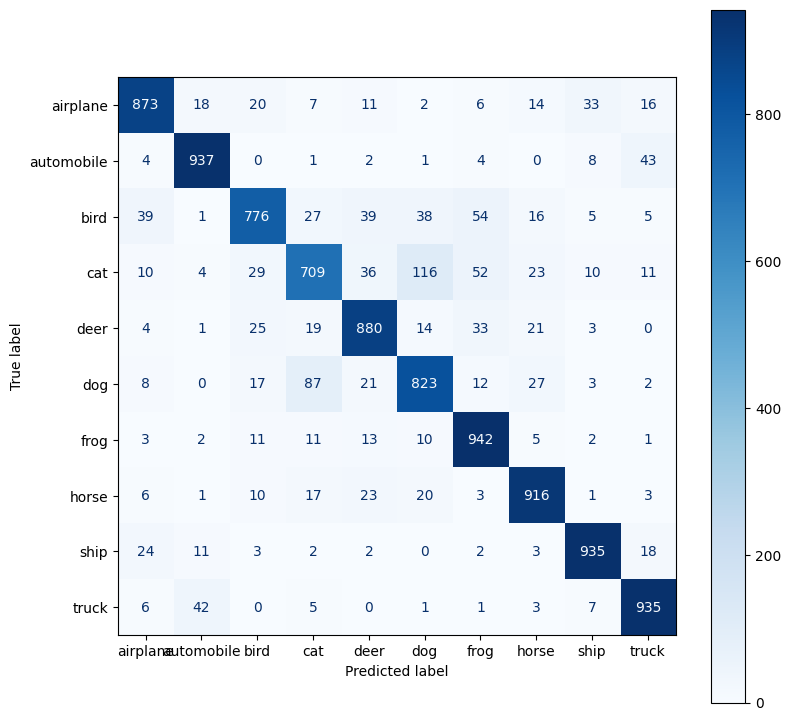

In [28]:
# Converting the predictions into label index 
y_pred_labels = np.argmax(y_pred, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy_cnn = accuracy_score(y_test, y_pred_labels)
print(f"CNN Accuracy: {accuracy_cnn:.2f}", )



# utility function to draw confusion matrix with maplotlon
def show_confusion_matrix(y_test, y_pred):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", display_labels=cifar10_class_names)
    fig = cm_display.ax_.get_figure() 
    fig.set_figwidth(9)
    fig.set_figheight(9) 



# Show confusion matrix for the decision tree
show_confusion_matrix(y_test, y_pred_labels)

### Model Deployment

#### Deploy Saved Model for the  REST Inference  Service 

We deploy the saved model to the *deployed_models* directory, which is used by the inference service. If a model has been deployed before, they will be renamed with a version appended to their filenames. eg *simple-cifar10.v1.h5* and be kept as backups and tracking purposes. 

*This deployment code is for educational purposes only and it is not for production. Use an MLOPs framework for production-grade pipeline*

In [29]:
import os
import shutil
import glob
import re

import os
import shutil
import glob
import re

def deploy_model(model_deployment_directory, file_name):        
    # Construct the destination file path
    destination_path = os.path.join(model_deployment_directory, os.path.basename(file_name))
    # Check if a file with the same name already exists in the destination directory
    if os.path.exists(destination_path):
        # Find all versions of the file in the destination directory
        glob_pattern = os.path.join(model_deployment_directory, file_name.replace('.h5', '*.h5'))

        # Find all versions of the file in the destination directory
        existing_versions = glob.glob(glob_pattern)

        # Extract the version numbers from the file names
        version_numbers = []
        for file in existing_versions:
            match = re.search('v(\d+).h5$', file)
            if match:
                version_numbers.append(int(match.group(1)))

        # Determine the version number for the existing file
        if version_numbers:
            new_version_number = max(version_numbers) + 1
        else:
            new_version_number = 1

        # Construct the new file name with the version number for the existing file
        new_file_name = file_name.replace('.h5', '') + '.v' + str(new_version_number) + '.h5'
        new_destination_path = os.path.join(model_deployment_directory,os.path.basename(new_file_name))

        # Rename the existing file
        os.rename(destination_path, new_destination_path)
        print(f"Existing model renamed to: {new_destination_path}")

    # Copy the new file with its original name
    print(file_name, destination_path)
    shutil.copy(file_name, destination_path)
    print(f"New model deployed to: {destination_path}")
        



Existing model renamed to: ../api/deployed_models/simple-cifar10.v1.h5
../models/simple-cifar10.h5 ../api/deployed_models/simple-cifar10.h5
New model deployed to: ../api/deployed_models/simple-cifar10.h5


## Secure Deployment with Model Encryption

In [47]:
model_path = '../models/simple-cifar10.h5'

import os
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.ciphers.aead import AESGCM

def encrypt(data, key):
    nonce = os.urandom(12)  # AESGCM nonce length
    aesgcm = AESGCM(key)
    encrypted_data = aesgcm.encrypt(nonce, data, None)
    return nonce + encrypted_data

with open(model_path,'rb') as model_file:
        model_data = model_file.read()

def load_key(file_path):
    try:
        with open(file_path, 'rb') as file:  # Read the key as bytes
            key = file.read().strip()  # Read the key and strip any extra whitespace
        return key
    except FileNotFoundError:
        print("The file was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

key_path = '../keys/service.key'

key = load_key(key_path)
if key is not None:
    encrypted_model = encrypt(model_data, key)
    # Save the result to a file
    with open(model_path + '.enc', 'wb') as file:
        file.write(encrypted_model)

# Directory where the file will be copied
model_deployment_directory = '../api/deployed_models'

# Check if model deployment directory exists, if not, create it
if not os.path.exists(model_deployment_directory):
    os.makedirs(model_deployment_directory)
deploy_model(model_deployment_directory, model_path + '.enc')


../models/simple-cifar10.h5.enc ../api/deployed_models/simple-cifar10.h5.enc
New model deployed to: ../api/deployed_models/simple-cifar10.h5.enc


Hash the encrypted model to use for  Integrity  Verification
use the command 
openssl dgst -sha256 ../api/deployed_models/simple-cifar10.h5.enc
and use the hash digets in the docker-compose file to pass it as environment variable to the inferene service 